# Regression of pH range using machine learning (Random Forest)

In [1]:
HOME_DIR = '/Users/datatranslators/Documents/GitHub/acido_CEST_Machine_Learning/'
DESTINATION = 'outputs'

## Libraries

In [2]:
#libs
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
import pandas as pd
import numpy as np
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn import metrics

from sklearn.pipeline import Pipeline
from sklearn import preprocessing as pp
import seaborn as sns

from sklearn.feature_selection import SelectFromModel

from joblib import dump, load

## Data

In [3]:
# load data
acidoCEST_ML = pd.read_parquet('../clean_data/acido_CEST_MRI_Iopamidol.parquet.gzip')

# drop columns we cannot measure or that are redundant
cols_2_drop = ['ApproT1(sec)','Temp','ExpB0(ppm)','FILE','Conc(mM)']
acidoCEST_ML = acidoCEST_ML.drop(cols_2_drop, axis = 1)

# define experimental columns -- > things we measure other than CEST
exper_cols = [ 'ExpB1(percent)', 'ExpB0(Hz)', 'SatPower(uT)',  'SatTime(ms)','ExpT1(ms)', 'ExpT2(ms)']

# used during development
#acidoCEST_ML  = acidoCEST_ML.sample( n = 5_00)

acidoCEST_ML.shape

(20000, 88)

## Functions

In [4]:
# Regression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor as RFR

def train_RFR(Xdata, pH_observed, create_fig=True, verbose=3):
    print('------------------ Random Forest ------------------ ')
    print()
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(Xdata, pH_observed, test_size=0.30, random_state=42)
        
        
    
    max_f = int( 0.5 * Xdata.shape[1] )
        
    # Regression
    #param_grid = dict( n_estimators = [100,200,500], max_depth =[None], max_features=['sqrt','log2','auto',max_f], max_samples=[.10,.50], min_samples_leaf=[.01,.50] )

    
    param_grid = dict( n_estimators = [100,200,500], max_depth =[10,20,40,None] )

    
    # grid parameters
    scorer = metrics.make_scorer( metrics.r2_score, greater_is_better = True) 
    
    #
    estimator = GridSearchCV( RFR(random_state = 42,  n_jobs = -1), param_grid, verbose = verbose, cv = 3, n_jobs= 1, scoring=scorer )

    # fit
    estimator.fit(X_train, y_train)

    score_train = np.round( 100 * metrics.mean_absolute_percentage_error(y_train , estimator.predict(X_train)), 2)
    score_test  = np.round( 100 * metrics.mean_absolute_percentage_error(y_test , estimator.predict(X_test)), 2)

    #score on pH units
    score_pH_train = np.mean( np.abs(  y_train -  estimator.predict(X_train) ) )
    score_pH_test = np.mean( np.abs(  y_test -  estimator.predict(X_test) ) )


    m = f' mean absolute percentage error \n train = {score_train} % \n test  = {score_test} %'
    m2 = f'\n pH units |error : \ntrain = {score_pH_train:.3f} \n test = {score_pH_test:.3f}'
    
    #print(', '.join(Xdata.columns.to_list()))
    print()
    print(m,'\n',m2,'\n')
    print(estimator.best_estimator_)

    # scores
    scores = dict()
    scores['mae_train'] = score_train
    scores['mae_test'] = score_test
    scores['pH_train'] = score_pH_train
    scores['pH_test'] = score_pH_test

    test_data = dict()
    test_data['X'] = X_test
    test_data['Y'] = y_test
        
    if create_fig == True:
        plt.figure()
        sns.regplot(x = estimator.best_estimator_.predict(X_train), y =  y_train)
        plt.xlabel('\n Predicted pH')
        plt.ylabel('Measured pH \n')
        plt.title('Train Random Forest')

        plt.figure()
        sns.regplot(x = estimator.best_estimator_.predict(X_test), y =  y_test)
        plt.xlabel('\n Predicted pH')
        plt.ylabel('Measured pH \n')
        plt.title('Test Random Forest')

        


    
    return estimator.best_estimator_, scores, test_data

def save_and_print(RFO, name='foo'):
    print('-----')
    for k in RFO.get_params().keys():
        print(f'{k}: {RFO.get_params()[k]}')
    
    dump(RFO, HOME_DIR + DESTINATION + f'/{name}.joblib') 

# Results

## Random Forest

### 4.2 and 5.6 only

------------------ Random Forest ------------------ 

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END ....max_depth=10, n_estimators=100;, score=0.234 total time=   0.3s
[CV 2/3] END ....max_depth=10, n_estimators=100;, score=0.225 total time=   0.2s
[CV 3/3] END ....max_depth=10, n_estimators=100;, score=0.235 total time=   0.2s
[CV 1/3] END ....max_depth=10, n_estimators=200;, score=0.235 total time=   0.3s
[CV 2/3] END ....max_depth=10, n_estimators=200;, score=0.226 total time=   0.4s
[CV 3/3] END ....max_depth=10, n_estimators=200;, score=0.235 total time=   0.3s
[CV 1/3] END ....max_depth=10, n_estimators=500;, score=0.234 total time=   0.8s
[CV 2/3] END ....max_depth=10, n_estimators=500;, score=0.226 total time=   0.8s
[CV 3/3] END ....max_depth=10, n_estimators=500;, score=0.233 total time=   0.8s
[CV 1/3] END ....max_depth=20, n_estimators=100;, score=0.145 total time=   0.3s
[CV 2/3] END ....max_depth=20, n_estimators=100;, score=0.138 total time=  

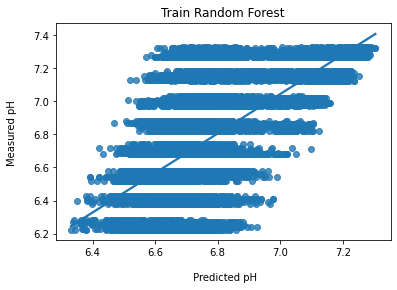

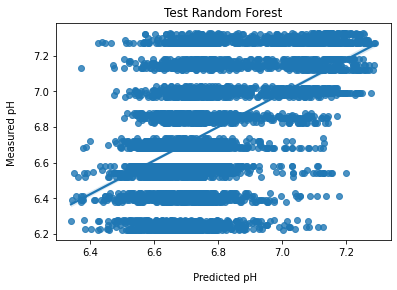

In [7]:
%%time

Xdata = acidoCEST_ML[['4.2','5.6']]
Y     = acidoCEST_ML.pH

RF_regressor_4256, _, _ = train_RFR(Xdata,Y)

save_and_print(RF_regressor_4256, name='RF_regressor_4256')

#### Feature Importance

Text(0.5, 1.0, 'Feature Importance for Regression of pH \n Only CEST features were used\n')

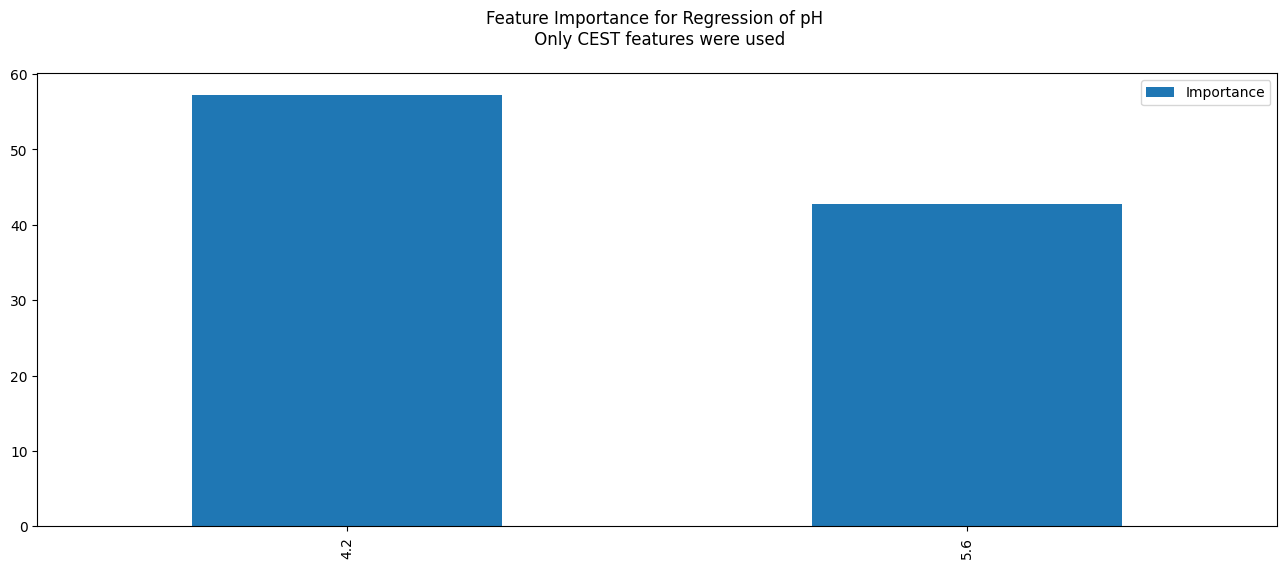

In [8]:
I = pd.DataFrame( 100 * RF_regressor_4256.feature_importances_, columns=['Importance'], index = Xdata.columns)
_, ax = plt.subplots(dpi = 100, figsize=(16,6))
I.plot(kind='bar', ax = ax, rot=90)
plt.title('Feature Importance for Regression of pH \n Only CEST features were used\n')

### Only CEST data

------------------ Random Forest ------------------ 

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END ....max_depth=10, n_estimators=100;, score=0.607 total time=   4.4s
[CV 2/3] END ....max_depth=10, n_estimators=100;, score=0.603 total time=   4.6s
[CV 3/3] END ....max_depth=10, n_estimators=100;, score=0.594 total time=   4.6s
[CV 1/3] END ....max_depth=10, n_estimators=200;, score=0.606 total time=   9.2s
[CV 2/3] END ....max_depth=10, n_estimators=200;, score=0.604 total time=   8.7s
[CV 3/3] END ....max_depth=10, n_estimators=200;, score=0.595 total time=   8.6s
[CV 1/3] END ....max_depth=10, n_estimators=500;, score=0.607 total time=  21.5s
[CV 2/3] END ....max_depth=10, n_estimators=500;, score=0.605 total time=  20.6s
[CV 3/3] END ....max_depth=10, n_estimators=500;, score=0.597 total time=  20.7s
[CV 1/3] END ....max_depth=20, n_estimators=100;, score=0.660 total time=   6.0s
[CV 2/3] END ....max_depth=20, n_estimators=100;, score=0.661 total time=  

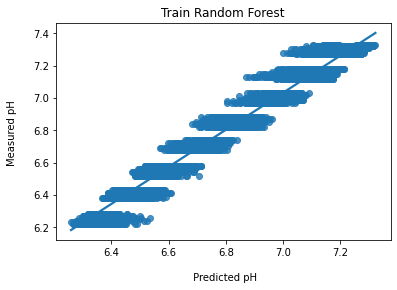

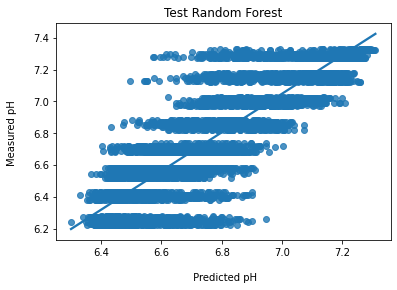

In [9]:
%%time

Xdata = acidoCEST_ML.drop(exper_cols + ['pH'],axis=1)
Ydata = acidoCEST_ML.pH 

reg_rf_only_CEST, _, _  = train_RFR(Xdata,Ydata)
save_and_print(reg_rf_only_CEST, name='RF_regressor_all_CEST')

#### Feature Importance

Text(0.5, 1.0, 'Feature Importance for Regression of pH \n Only CEST features were used\n')

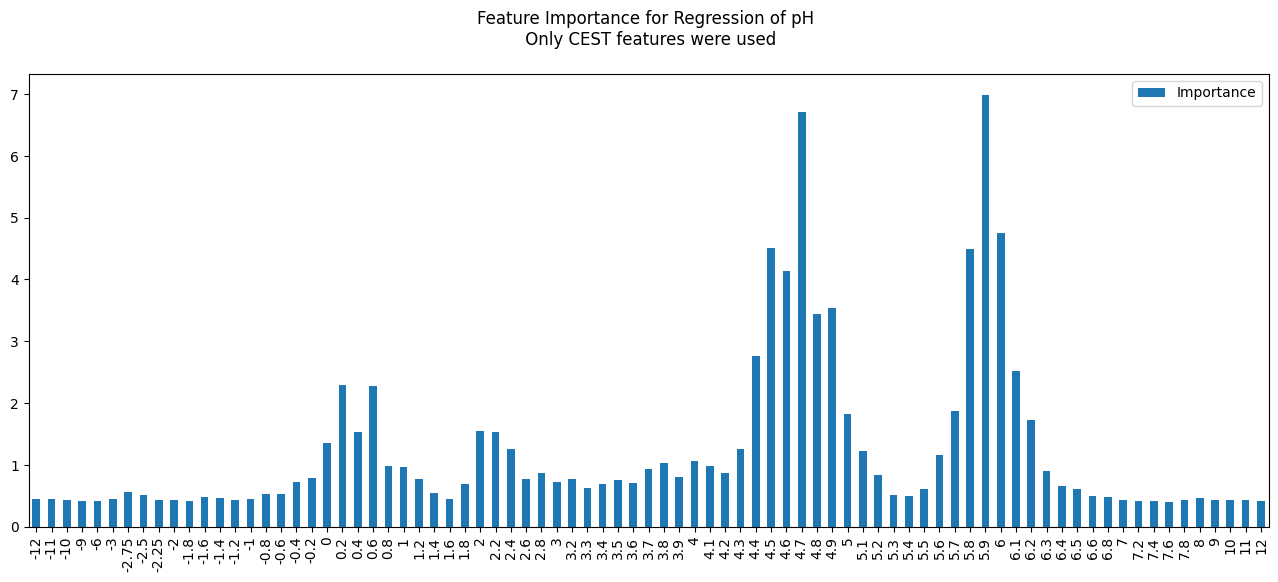

In [10]:
I = pd.DataFrame( 100 * reg_rf_only_CEST.feature_importances_, columns=['Importance'], index = Xdata.columns)
_, ax = plt.subplots(dpi = 100, figsize=(16,6))
I.plot(kind='bar', ax = ax, rot=90)
plt.title('Feature Importance for Regression of pH \n Only CEST features were used\n')

### All data

------------------ Random Forest ------------------ 

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END ....max_depth=10, n_estimators=100;, score=0.748 total time=   4.3s
[CV 2/3] END ....max_depth=10, n_estimators=100;, score=0.761 total time=   4.5s
[CV 3/3] END ....max_depth=10, n_estimators=100;, score=0.764 total time=   4.8s
[CV 1/3] END ....max_depth=10, n_estimators=200;, score=0.748 total time=   8.6s
[CV 2/3] END ....max_depth=10, n_estimators=200;, score=0.765 total time=   8.9s
[CV 3/3] END ....max_depth=10, n_estimators=200;, score=0.765 total time=   8.8s
[CV 1/3] END ....max_depth=10, n_estimators=500;, score=0.746 total time=  20.5s
[CV 2/3] END ....max_depth=10, n_estimators=500;, score=0.765 total time=  20.6s
[CV 3/3] END ....max_depth=10, n_estimators=500;, score=0.766 total time=  20.5s
[CV 1/3] END ....max_depth=20, n_estimators=100;, score=0.921 total time=   5.7s
[CV 2/3] END ....max_depth=20, n_estimators=100;, score=0.925 total time=  

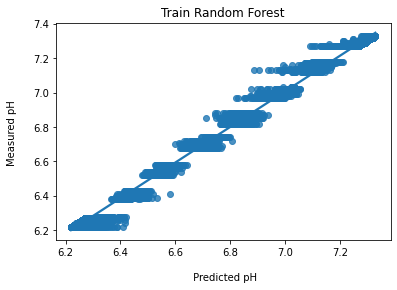

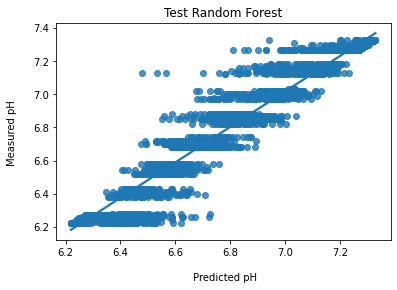

In [11]:
%%time
Xdata = acidoCEST_ML.drop( ['pH'],axis=1) 
Ydata = acidoCEST_ML.pH

reg_rf_all, _, _  = train_RFR(Xdata,Ydata)
save_and_print(reg_rf_all, name='RF_regressor_all_DATA')

#### Feature Importance

Text(0.5, 1.0, 'Feature Importance for Regression of pH \n All features were used\n')

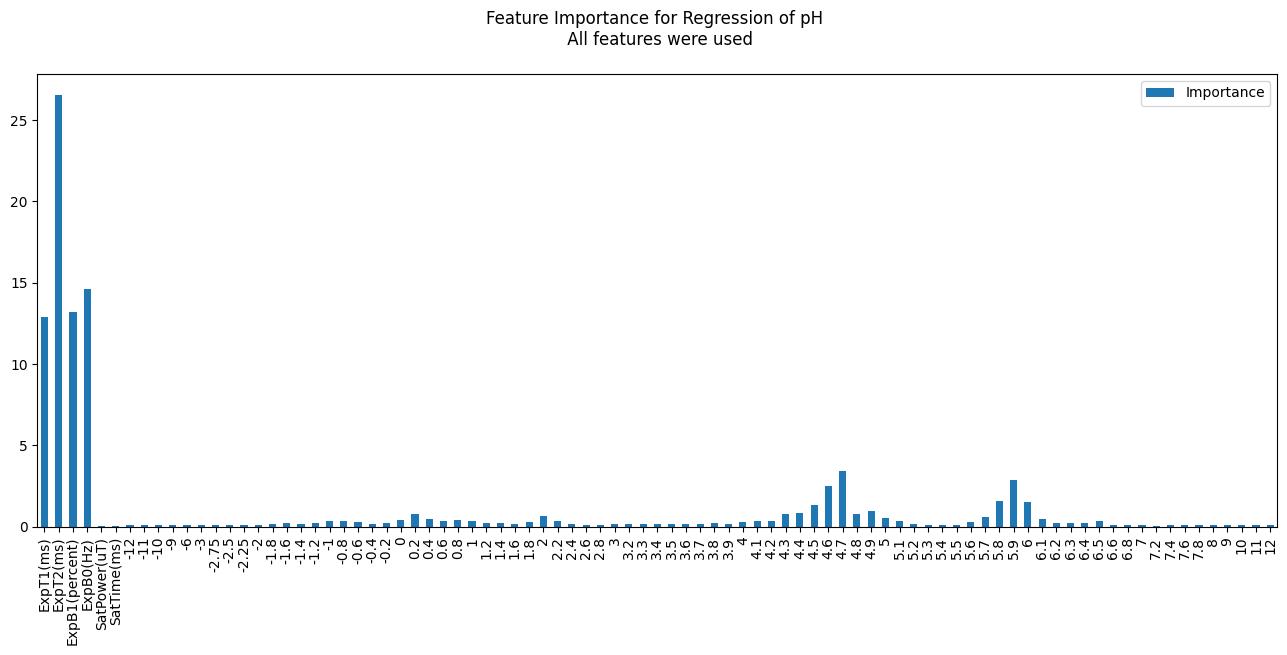

In [12]:
I = pd.DataFrame( 100 * reg_rf_all.feature_importances_, columns=['Importance'], index = Xdata.columns)
_, ax = plt.subplots(dpi = 100, figsize=(16,6))
I.plot(kind='bar', ax = ax, rot=90)
plt.title('Feature Importance for Regression of pH \n All features were used\n')

### Select features by recursive Feature elimination & Train

Index(['ExpT1(ms)', 'ExpT2(ms)', 'ExpB1(percent)', 'ExpB0(Hz)', '4.5', '4.6',
       '4.7', '5.8', '5.9', '6'],
      dtype='object')
------------------ Random Forest ------------------ 

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END ....max_depth=10, n_estimators=100;, score=0.768 total time=   0.5s
[CV 2/3] END ....max_depth=10, n_estimators=100;, score=0.780 total time=   0.5s
[CV 3/3] END ....max_depth=10, n_estimators=100;, score=0.769 total time=   0.5s
[CV 1/3] END ....max_depth=10, n_estimators=200;, score=0.770 total time=   0.9s
[CV 2/3] END ....max_depth=10, n_estimators=200;, score=0.783 total time=   1.0s
[CV 3/3] END ....max_depth=10, n_estimators=200;, score=0.775 total time=   0.9s
[CV 1/3] END ....max_depth=10, n_estimators=500;, score=0.766 total time=   2.4s
[CV 2/3] END ....max_depth=10, n_estimators=500;, score=0.781 total time=   2.6s
[CV 3/3] END ....max_depth=10, n_estimators=500;, score=0.779 total time=   2.5s
[CV 1/3] END ....max_d

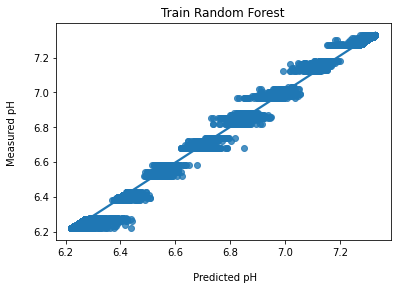

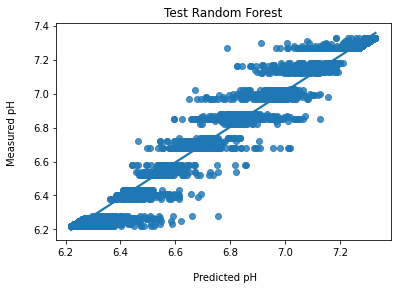

In [13]:
%%time
selected_RF = SelectFromModel( reg_rf_all  , max_features=20) 
selected_RF.fit(Xdata, Ydata)
cols = Xdata.columns[selected_RF.get_support()]

print(cols)

Xdata = acidoCEST_ML[cols]
Ydata = acidoCEST_ML.pH

reg_rf_selected_features, _, test_data_selected_features  = train_RFR(Xdata,Ydata)

save_and_print(reg_rf_selected_features, name='RF_regressor_selected')

#### Feature Importance

Text(0.5, 1.0, 'Feature Importance for Regression of pH \n All features from recursive elimination were used\n')

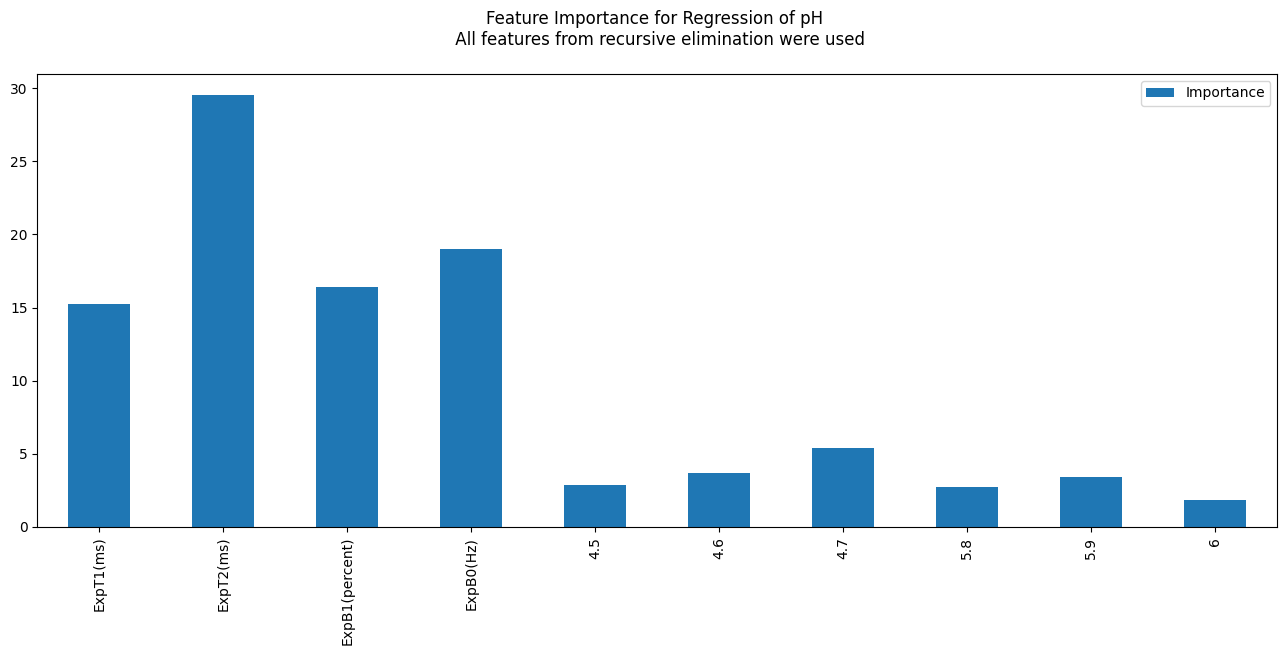

In [14]:
I = pd.DataFrame( 100 * reg_rf_selected_features.feature_importances_, columns=['Importance'], index = Xdata.columns)
_, ax = plt.subplots(dpi = 100, figsize=(16,6))
I.plot(kind='bar', ax = ax, rot=90)
plt.title('Feature Importance for Regression of pH \n All features from recursive elimination were used\n')

## Save predictions with selected

In [15]:
yhat = reg_rf_selected_features.predict( test_data_selected_features['X'] )

out = pd.DataFrame(yhat, columns=['Predicted_pH_RFReg_TEST'])
out['Measured_pH_TEST'] = test_data_selected_features['Y'].values
out.to_csv('../outputs/RF_reg_TEST_pred.csv')

out

,Predicted_pH_RFReg_TEST,Measured_pH_TEST
0,6.36566,6.28
1,7.16226,7.27
2,7.13826,7.14
3,6.25992,6.26
4,6.81954,6.87
...,...,...
5995,7.11768,7.13
5996,6.52048,6.52
5997,6.25126,6.25
5998,7.27526,7.29


## Remove B1 if selected an important feature

['ExpT1(ms)', 'ExpT2(ms)', 'ExpB0(Hz)', '4.5', '4.6', '4.7', '5.8', '5.9', '6']
------------------ Random Forest ------------------ 

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END ....max_depth=10, n_estimators=100;, score=0.769 total time=   0.5s
[CV 2/3] END ....max_depth=10, n_estimators=100;, score=0.770 total time=   0.5s
[CV 3/3] END ....max_depth=10, n_estimators=100;, score=0.776 total time=   0.5s
[CV 1/3] END ....max_depth=10, n_estimators=200;, score=0.770 total time=   0.9s
[CV 2/3] END ....max_depth=10, n_estimators=200;, score=0.774 total time=   1.0s
[CV 3/3] END ....max_depth=10, n_estimators=200;, score=0.776 total time=   1.0s
[CV 1/3] END ....max_depth=10, n_estimators=500;, score=0.767 total time=   2.4s
[CV 2/3] END ....max_depth=10, n_estimators=500;, score=0.774 total time=   2.6s
[CV 3/3] END ....max_depth=10, n_estimators=500;, score=0.778 total time=   2.6s
[CV 1/3] END ....max_depth=20, n_estimators=100;, score=0.936 total time=   

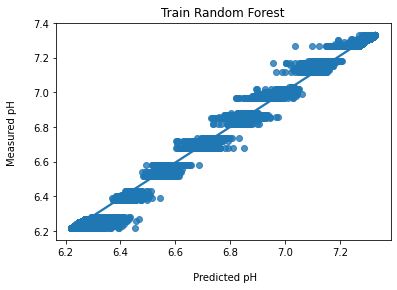

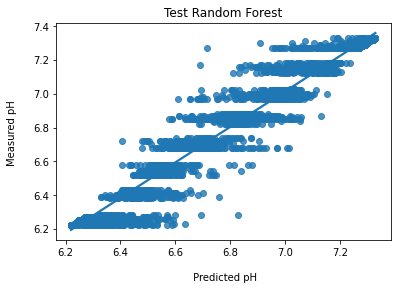

In [16]:
%%time

cols_without_B1 = [x for x in cols if 'B1' not in x ]
print(cols_without_B1)

Xdata = acidoCEST_ML[cols_without_B1]
Ydata = acidoCEST_ML.pH

reg_rf_RFE_noB1, _, _  = train_RFR(Xdata,Ydata)
save_and_print(reg_rf_RFE_noB1, name='RF_regressor_selected_no_B1')

## Effect of number of  estimators using Recursive Feature elimination features

------------------ Random Forest ------------------ 

RandomForestRegressor(max_depth=64, n_estimators=160, n_jobs=-1,
                      random_state=42)


Text(0, 0.5, 'Mean R2 score \n')

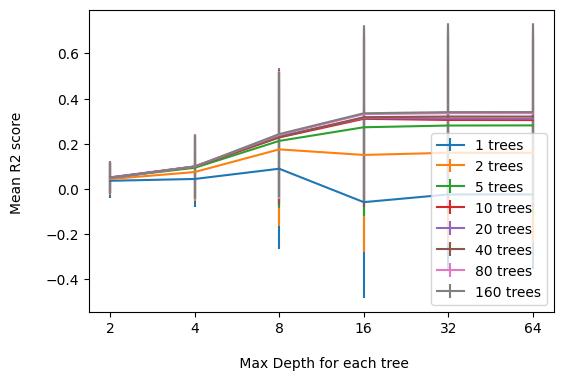

In [17]:
def train_RFR_02(Xdata, pH_observed):
    print('------------------ Random Forest ------------------ ')
    print()
    # grid
    param_grid = dict( n_estimators = [1,2,5,10,20,40,80,160], max_depth = [2**(x) for x in [1,2,3,4,5,6]])

    
    # grid parameters
    scorer = metrics.make_scorer( metrics.r2_score, greater_is_better = True) 
    
    #
    estimator = GridSearchCV( RFR(random_state = 42,  n_jobs = -1), param_grid, verbose = 0, cv = 10, n_jobs= 1, scoring=scorer )

    # fit
    estimator.fit(Xdata, pH_observed)

    score_train = np.round( 100 * metrics.mean_absolute_percentage_error(pH_observed , estimator.predict(Xdata)), 2)
    score_test  = np.round( 100 * metrics.mean_absolute_percentage_error(pH_observed , estimator.predict(Xdata)), 2)



    m = f' mean absolute percentage error \n train = {score_train} % \n test  = {score_test} %'
    
    print(estimator.best_estimator_)
    
    return estimator.best_estimator_, estimator

reg, CV = train_RFR_02(Xdata, Ydata)

R = pd.DataFrame()

pars = ['param_max_depth', 'param_n_estimators','std_test_score','mean_test_score']

for p in pars:
    R[p] = CV.cv_results_[p]

R['param_max_depth'] = R['param_max_depth'].astype(str) 
    
plt.figure(dpi=100)

for n  in R.param_n_estimators.unique():
    scores = R[R.param_n_estimators == n]
    plt.errorbar(x=scores['param_max_depth'], y=scores['mean_test_score'], yerr=scores['std_test_score'])
    
plt.legend([f'{x} trees' for x in R.param_n_estimators.unique()])

plt.xlabel('\n Max Depth for each tree')

plt.ylabel('Mean R2 score \n')

## Sat Time vs Sat Power Matrix

In [18]:
def SatTime_vs_SatPower(trainer, predictors, verbose=1):
    sat_times = acidoCEST_ML['SatTime(ms)'].unique()
    sat_times.sort()

    sat_powers = acidoCEST_ML['SatPower(uT)'].unique()
    sat_powers.sort()
    
    heat_map = pd.DataFrame(np.zeros( (len(sat_powers), len(sat_powers))), index=sat_powers, columns=sat_times)
    
    for t in sat_times:
        for p in sat_powers:
            
            print( f"""
            ===========================================
            Sat Powwer = {p} | Sat time = {t}
            
            """
                 )
            
            #select data subset
            D = acidoCEST_ML[(acidoCEST_ML['SatTime(ms)'] == t) & (acidoCEST_ML['SatPower(uT)'] == p) ]
            
            #D = D.sample(frac=.05) #for dev
            
            Xdata = D[predictors]
            Ydata = D['pH']
        
            regressor, scores, _ =trainer(Xdata,Ydata, create_fig=False, verbose=verbose)
            heat_map.loc[p,:][t] = scores['mae_test']
            
    

    heat_map.columns = [str(int(x/1000)) + ' sec'  for x in heat_map.columns]
    heat_map.index   = [f'{int(x)} uT' for  x in heat_map.index ]
    
    
    return heat_map


def plot_heatmap(HM, features = '', ML=''):
    _, ax = plt.subplots(dpi=200)

    cols_ = list(HM.columns)
    cols_.sort()

    idx = list(HM.index)
    idx.sort()
    
    sns.heatmap(HM.loc[idx,:][cols_], cmap='rainbow',annot=True,linewidths=.1,ax=ax)
    plt.xlabel('\n Saturation Time')
    plt.ylabel('Saturation Power \n')
    plt.title(f'Mean Abs. Error (%) in the pH estimate \n {ML} \n {features}')

    plt.savefig(f'../figs/MATRIX_regression_{ML}_{features}.png',bbox_inches='tight')

### 4.2 and 5.6 ppm

In [19]:
hm01 = SatTime_vs_SatPower(train_RFR, predictors=['4.2','5.6'], verbose=0)


            Sat Powwer = 1.0 | Sat time = 1000
            
            
------------------ Random Forest ------------------ 


 mean absolute percentage error 
 train = 2.99 % 
 test  = 4.59 % 
 
 pH units |error : 
train = 0.202 
 test = 0.310 

RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=42)

            Sat Powwer = 2.0 | Sat time = 1000
            
            
------------------ Random Forest ------------------ 


 mean absolute percentage error 
 train = 1.94 % 
 test  = 3.82 % 
 
 pH units |error : 
train = 0.130 
 test = 0.258 

RandomForestRegressor(max_depth=10, n_estimators=500, n_jobs=-1,
                      random_state=42)

            Sat Powwer = 3.0 | Sat time = 1000
            
            
------------------ Random Forest ------------------ 


 mean absolute percentage error 
 train = 1.51 % 
 test  = 3.33 % 
 
 pH units |error : 
train = 0.102 
 test = 0.226 

RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=42)

            Sat Poww

##### figure

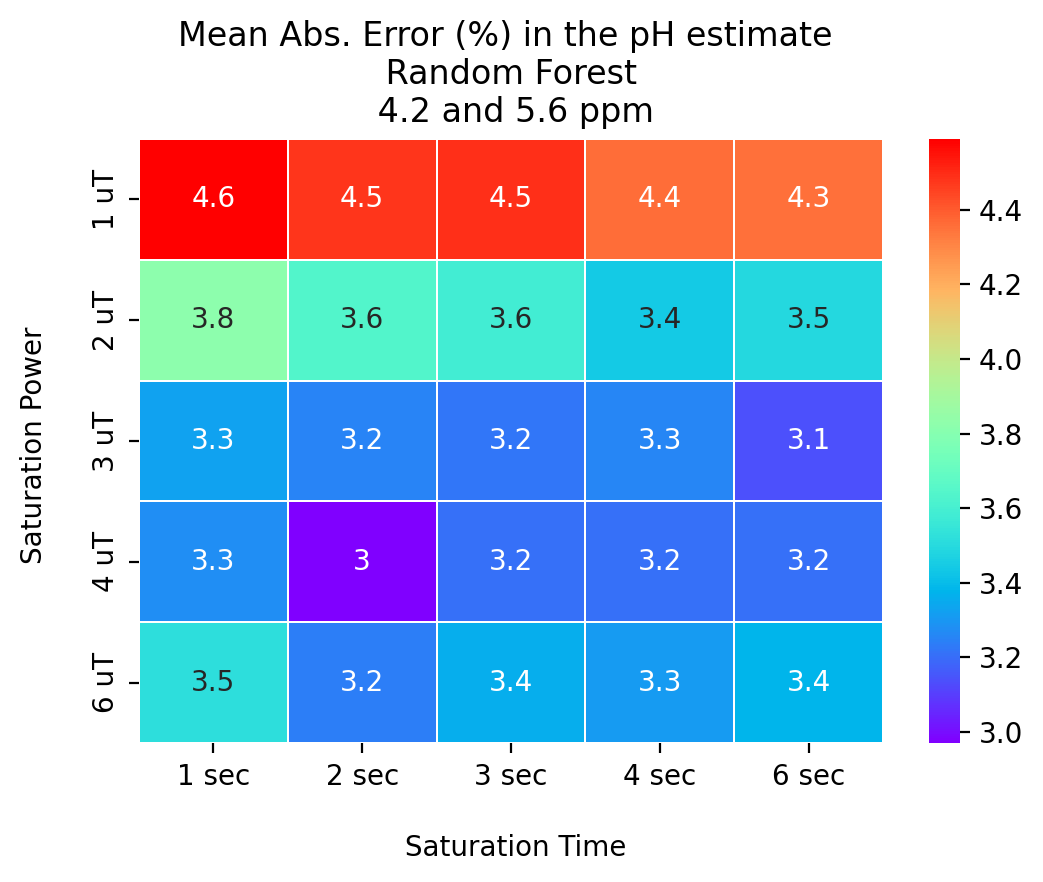

In [20]:
plot_heatmap(hm01, features = '4.2 and 5.6 ppm', ML='Random Forest')

### Selected Features(including B1)

In [21]:
%%time
sel_f = list(reg_rf_selected_features.feature_names_in_)
hm02 = SatTime_vs_SatPower(train_RFR, predictors=sel_f, verbose=0)


            Sat Powwer = 1.0 | Sat time = 1000
            
            
------------------ Random Forest ------------------ 


 mean absolute percentage error 
 train = 1.36 % 
 test  = 3.67 % 
 
 pH units |error : 
train = 0.091 
 test = 0.248 

RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=42)

            Sat Powwer = 2.0 | Sat time = 1000
            
            
------------------ Random Forest ------------------ 


 mean absolute percentage error 
 train = 1.1 % 
 test  = 2.76 % 
 
 pH units |error : 
train = 0.074 
 test = 0.187 

RandomForestRegressor(max_depth=10, n_estimators=500, n_jobs=-1,
                      random_state=42)

            Sat Powwer = 3.0 | Sat time = 1000
            
            
------------------ Random Forest ------------------ 


 mean absolute percentage error 
 train = 0.82 % 
 test  = 2.24 % 
 
 pH units |error : 
train = 0.055 
 test = 0.151 

RandomForestRegressor(max_depth=40, n_estimators=500, n_jobs=-1,
                 

##### figure

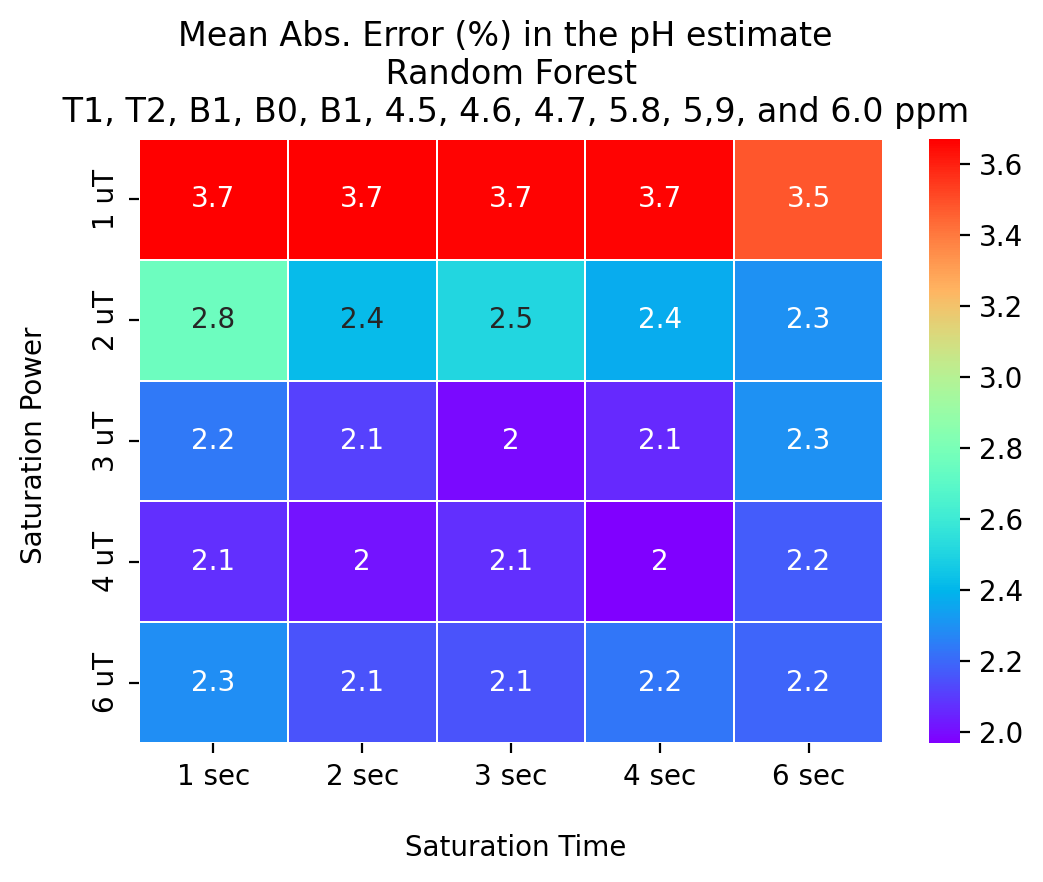

In [22]:
plot_heatmap(hm02, features = 'T1, T2, B1, B0, B1, 4.5, 4.6, 4.7, 5.8, 5,9, and 6.0 ppm', ML='Random Forest')

### Selected Features(`excluding` B1)

In [23]:
hm03 = SatTime_vs_SatPower(train_RFR, predictors=[x for x in  sel_f if 'B1' not in x ], verbose=0)


            Sat Powwer = 1.0 | Sat time = 1000
            
            
------------------ Random Forest ------------------ 


 mean absolute percentage error 
 train = 1.36 % 
 test  = 3.71 % 
 
 pH units |error : 
train = 0.092 
 test = 0.251 

RandomForestRegressor(max_depth=20, n_estimators=500, n_jobs=-1,
                      random_state=42)

            Sat Powwer = 2.0 | Sat time = 1000
            
            
------------------ Random Forest ------------------ 


 mean absolute percentage error 
 train = 1.01 % 
 test  = 2.77 % 
 
 pH units |error : 
train = 0.068 
 test = 0.188 

RandomForestRegressor(max_depth=20, n_estimators=500, n_jobs=-1,
                      random_state=42)

            Sat Powwer = 3.0 | Sat time = 1000
            
            
------------------ Random Forest ------------------ 


 mean absolute percentage error 
 train = 0.83 % 
 test  = 2.27 % 
 
 pH units |error : 
train = 0.056 
 test = 0.154 

RandomForestRegressor(n_estimators=500, n_job

##### figure

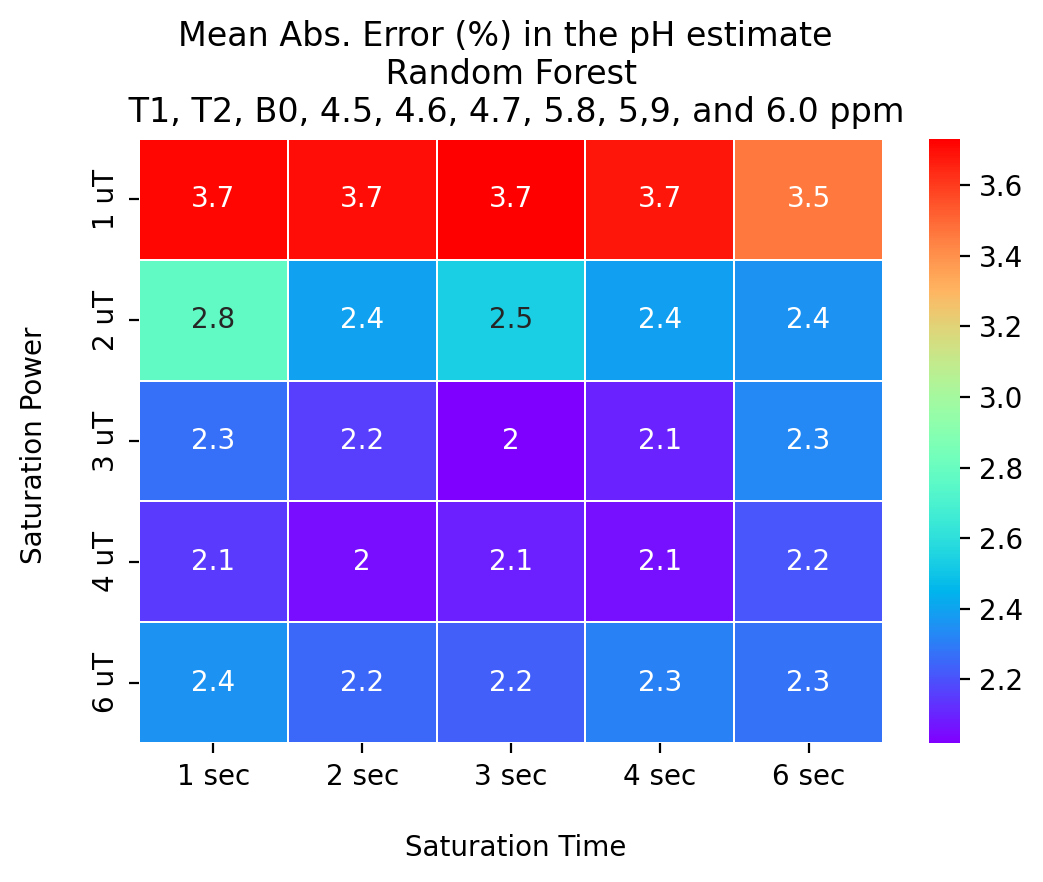

In [24]:
plot_heatmap(hm03, features = 'T1, T2, B0, 4.5, 4.6, 4.7, 5.8, 5,9, and 6.0 ppm', ML='Random Forest')